In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

# %cd /content/drive/MyDrive/MECD/2º\ ano/Tese/Implementação

In [5]:
# !sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended texlive-latex-recommended cm-super

In [6]:
# !pip install SciencePlots

In [7]:
import joblib  # For saving and loading models

import numpy as np  # NumPy for numerical operations
import pandas as pd  # Pandas for data manipulation

from sklearn.neighbors import KNeighborsRegressor  # K-Nearest Neighbors regressor
from sklearn.neural_network import MLPRegressor  # Multi-layer Perceptron regressor

from sklearn.metrics import (
    r2_score,  # R-squared score (Coefficient of determination)
    mean_absolute_error,  # Mean Absolute Error (MAE)
    mean_squared_error,  # Mean Squared Error (MSE)
    mean_absolute_percentage_error,  # Mean Absolute Percentage Error (MAPE)
)

import matplotlib.pyplot as plt  # Matplotlib for plotting
import seaborn as sns  # Seaborn for enhanced visualization

import scienceplots  # SciencePlots style for matplotlib
plt.style.use("science")  # Set the plot style to 'science'


In [8]:
train = pd.read_csv("./data/final_miami_datasets/no_history/train.csv", index_col=[0,1])
train_X = train.iloc[:, :-1]
train_y = train.iloc[:, -1]

val = pd.read_csv("./data/final_miami_datasets/no_history/val.csv")
val_X = val.iloc[:, :-1]
val_y = val.iloc[:, -1]

test = pd.read_csv("./data/final_miami_datasets/no_history/test.csv")
test_X = test.iloc[:, :-1]
test_y = test.iloc[:, -1]

In [9]:
train_X = train_X[["LON", "LAT", "SOG", "distanceToPort"]]
val_X = val_X[["LON", "LAT", "SOG", "distanceToPort"]]
test_X = test_X[["LON", "LAT", "SOG", "distanceToPort"]]

In [10]:
# Obter valores coom RTT <= 24h
rtt_less_24h = np.where(train_y.to_numpy() <= 24*60)[0]
train_X_24 = train_X.iloc[rtt_less_24h]
train_y_24 = train_y.iloc[rtt_less_24h]

rtt_less_24h = np.where(val_y.to_numpy() <= 24*60)[0]
val_X_24 = val_X.iloc[rtt_less_24h]
val_y_24 = val_y.iloc[rtt_less_24h]

rtt_less_24h = np.where(test_y.to_numpy() <= 24*60)[0]
test_X_24 = test_X.iloc[rtt_less_24h]
test_y_24 = test_y.iloc[rtt_less_24h]

In [11]:
train_X_24 = np.vstack((train_X_24.to_numpy(), val_X_24.to_numpy()))
train_y_24 = np.hstack((train_y_24.to_numpy(), val_y_24.to_numpy()))

In [12]:
print(max(train_y_24/60))
print(max(test_y_24/60))

24.0
24.0


In [13]:
knr = KNeighborsRegressor(n_neighbors=500, weights="distance", p=2)
mlp = MLPRegressor(hidden_layer_sizes=(22, 63), activation="tanh", solver="adam",
                   learning_rate_init=0.000243, early_stopping=True)

In [14]:
knr =knr.fit(train_X_24, train_y_24)
mlp = mlp.fit(train_X_24, train_y_24)

C:\Users\rendr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [15]:
joblib.dump(knr, "knr_basemodel.pkl")
joblib.dump(mlp, "mlp_basemodel.pkl")

['mlp_basemodel.pkl']

In [16]:
knr = joblib.load("./models/knr_basemodel.pkl")
mlp = joblib.load("./models/mlp_basemodel.pkl")

In [17]:
knr_preds = knr.predict(test_X_24.values)
mlp_preds = mlp.predict(test_X_24.values)

In [18]:
knr_preds_targets_df_24 = pd.DataFrame(data=np.vstack((knr_preds, test_y_24.values)).T, columns=["Preds", "Targets"])
mlp_preds_targets_df_24 = pd.DataFrame(data=np.vstack((mlp_preds, test_y_24.values)).T, columns=["Preds", "Targets"])

In [19]:
bins_24 = np.array([-1.0, 4.0, 8.0, 12.0, 16.0, 20.0, 25.0]) * 60
labels_24 = ["0-4", "4-8", "8-12", "12-16", "16-20", "20-24"]
knr_preds_targets_df_24["TargetBinned"] = pd.cut(knr_preds_targets_df_24["Targets"], bins=bins_24, labels=labels_24)
mlp_preds_targets_df_24["TargetBinned"] = pd.cut(mlp_preds_targets_df_24["Targets"], bins=bins_24, labels=labels_24)

In [20]:
mape = mean_absolute_percentage_error(knr_preds_targets_df_24["Targets"], knr_preds_targets_df_24["Preds"])
mae = mean_absolute_error(knr_preds_targets_df_24["Targets"], knr_preds_targets_df_24["Preds"])
rmse = mean_squared_error(knr_preds_targets_df_24["Targets"], knr_preds_targets_df_24["Preds"], squared=False)
r2 = r2_score(knr_preds_targets_df_24["Targets"], knr_preds_targets_df_24["Preds"])

metrics_knr_df_24 = pd.DataFrame(data=[[mape, mae, rmse, r2]],
                                 columns=["MAPE", "MAE", "RMSE", "R2"],
                                 index=["KNN"])

mape = mean_absolute_percentage_error(mlp_preds_targets_df_24["Targets"], mlp_preds_targets_df_24["Preds"])
mae = mean_absolute_error(mlp_preds_targets_df_24["Targets"], mlp_preds_targets_df_24["Preds"])
rmse = mean_squared_error(mlp_preds_targets_df_24["Targets"], mlp_preds_targets_df_24["Preds"], squared=False)
r2 = r2_score(mlp_preds_targets_df_24["Targets"], mlp_preds_targets_df_24["Preds"])

metrics_mlp_df_24 = pd.DataFrame(data=[[mape, mae, rmse, r2]],
                                 columns=["MAPE", "MAE", "RMSE", "R2"],
                                 index=["MLP"])

metrics_df_24 = pd.concat((metrics_knr_df_24, metrics_mlp_df_24), axis=0)

In [21]:
display(metrics_df_24)
print(metrics_df_24.style.to_latex())

,MAPE,MAE,RMSE,R2
KNN,0.240225,114.215517,179.175611,0.787010
MLP,0.242455,114.130277,177.135847,0.791832


\begin{tabular}{lrrrr}
 & MAPE & MAE & RMSE & R2 \\
KNN & 0.240225 & 114.215517 & 179.175611 & 0.787010 \\
MLP & 0.242455 & 114.130277 & 177.135847 & 0.791832 \\
\end{tabular}



In [22]:
knr_preds_targets_df_24["Error"] = knr_preds_targets_df_24["Targets"] - knr_preds_targets_df_24["Preds"]
mlp_preds_targets_df_24["Error"] = mlp_preds_targets_df_24["Targets"] - mlp_preds_targets_df_24["Preds"]

errors_df_24 = pd.concat((knr_preds_targets_df_24["Error"], mlp_preds_targets_df_24["Error"]), axis=1, keys=["KNN", "MLP"])
errors_df_24["TargetBinned"] = mlp_preds_targets_df_24["TargetBinned"]
errors_df_24.set_index(keys="TargetBinned", inplace=True)

errors_df_24 = errors_df_24.melt(value_vars=["KNN", "MLP"], var_name="Model", value_name="Error", ignore_index=False).reset_index()
errors_df_24["AbsError"] = errors_df_24["Error"].abs()

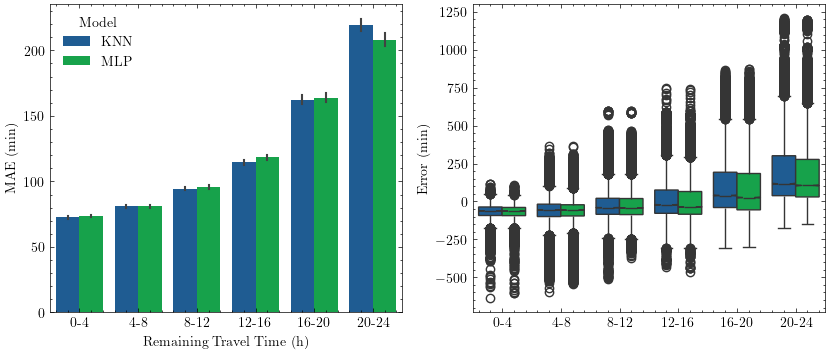

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.barplot(data=errors_df_24, x="TargetBinned", y="AbsError", hue="Model", estimator="mean", ax=axs[0])
axs[0].set_ylabel("MAE (min)")
axs[0].set_xlabel("Remaining Travel Time (h)")

sns.boxplot(data=errors_df_24, x="TargetBinned", y="Error", hue="Model", notch=True , ax=axs[1])
axs[1].set_ylabel("Error (min)")
axs[1].set_xlabel("")
axs[1].get_legend().remove()

plt.savefig("./figures/baseline_mae_by_time_miami_24")
plt.show()

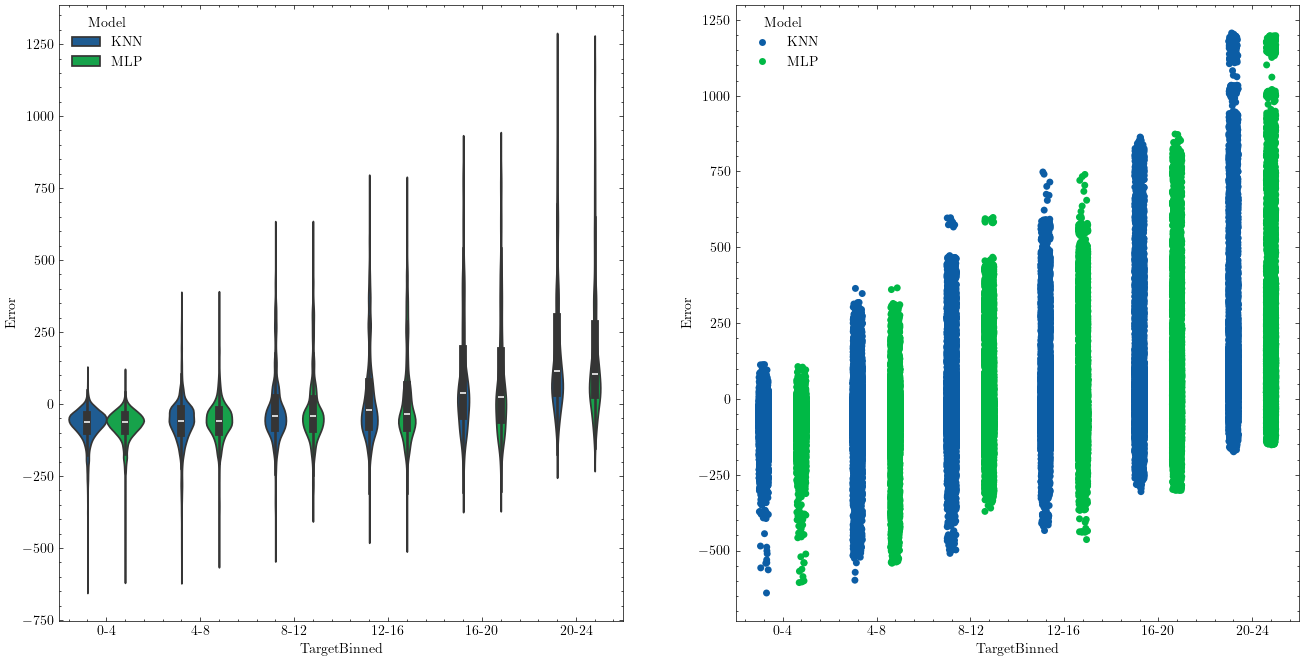

: 

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
sns.violinplot(data=errors_df_24, x="TargetBinned", y="Error", hue="Model", ax=axs[0])
sns.stripplot(data=errors_df_24, x="TargetBinned", y="Error", hue="Model", dodge=True, ax=axs[1])

#axs[0].set_ylabel("MAE (min)")
#axs[0].set_xlabel("Remaining Travel Time (h)")

plt.show()